# Linear Regression and Model Validation demonstration

Last revised: 06-Sep-2020 by Christian Forssén [christian.forssen@chalmers.se]

## Import modules

In [1]:
# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set('talk')

## Generate data

In [2]:
# Let us generate some data from a cubic model with noise
m = 100
minX = -3
maxX = 3
np.random.seed(1)
x = (maxX-minX) * np.random.rand(m, 1) + minX
# up to cubic features, plus random noise
theta_true = np.array([2, 1, 0.5, -0.25])
eps_noise = 1.
y = eps_noise * np.random.randn(m, 1)
for order in range(len(theta_true)):
    y += theta_true[order] * x**order

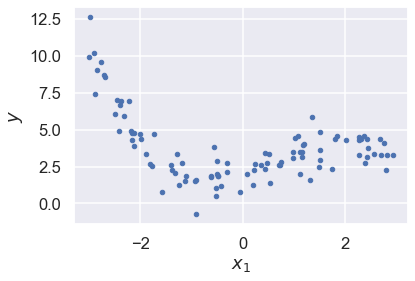

In [3]:
# Plot the data. It is pretty tricky to see the features
fig,ax = plt.subplots(1,1)

ax.plot(x, y, "b.")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$y$");

## Over- and underfitting

We will explore fitting to models that have both too many and too few features.

order 100: rms theta =  4.7e+12
order   3: rms theta =  1.2e+00
order   1: rms theta =  3.0e-01


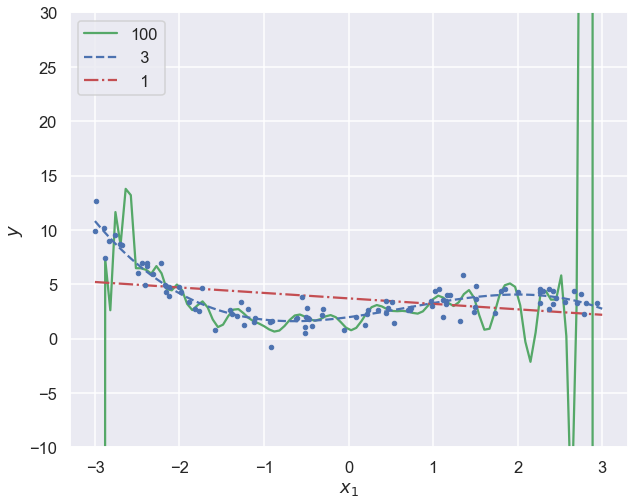

In [4]:
# For these fits we will employ scaling of the data
# We use the built-in StandardScaler to rescale the data to zero mean and unit variance.
# This will make the fit more stable
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

x_new=np.linspace(minX, maxX, 100).reshape(100, 1)

fig,ax = plt.subplots(1,1,figsize=(10,8))

for style, degree in (("g-", 100), ("b--", 3), ("r-.", 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    # Here we use a Pipeline that assembles several steps that we
    # also could have applied sequentially:
    # 1. The design matrix is created with the chosen polynomial features.
    # 2. The data is transformed to mean=0 and variance=1 
    #    (usually makes it numerically more stable)
    # 3. Perform the linear regression fit
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(x, y)
    y_newbig = polynomial_regression.predict(x_new)
    ax.plot(x_new, y_newbig, style, label=f'{degree:>3}')
    print(f'order {degree:>3}: rms theta = ',\
          f'{np.linalg.norm(lin_reg.coef_,ord=None)/order:3.1e}')


ax.plot(x, y, "b.")
ax.legend(loc="best")
ax.set_xlabel("$x_1$")
ax.set_ylim([-10,30])
ax.set_ylabel("$y$");

- Note how the high-degree polynomial produces a very wiggly curve that tries very hard to go through the training data. The model explodes near the edges where there is no more training data. 
- The first degree polynomial, on the other hand, fails to pick up some trends in the data that is clearly there. 

### Bias-variance tradeoff

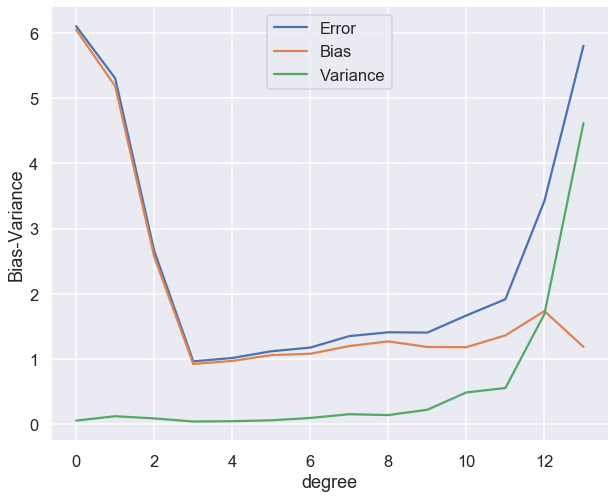

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

np.random.seed(2019)

n_boostraps = 100
maxdegree = 14

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = range(maxdegree)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

for degree in range(maxdegree):
    polybig_features = PolynomialFeatures(degree=degree)
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("lin_reg", lin_reg),
        ])

    y_pred = np.empty((y_test.shape[0], n_boostraps))
    for i in range(n_boostraps):
        x_, y_ = resample(x_train, y_train)
        # Evaluate the new model on the same test data each time.
        y_pred[:, i] = polynomial_regression.fit(x_, y_).predict(x_test).ravel()

    # Note: Expectations and variances taken w.r.t. different training
    # data sets, hence the axis=1. Subsequent means are taken across the test data
    # set in order to obtain a total value, but before this we have error/bias/variance
    # calculated per data point in the test set.
    # Note 2: The use of keepdims=True is important in the calculation of bias as this 
    # maintains the column vector form. Dropping this yields very unexpected results.
    error[degree] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(y_pred, axis=1, keepdims=True) )

fig,ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(polydegree, error, label='Error')
ax.plot(polydegree, bias, label='Bias')
ax.plot(polydegree, variance, label='Variance')
ax.legend(loc="best")
ax.set_xlabel("degree")
ax.set_ylabel("Bias-Variance");

## Regularized models

### Ridge regression

In [14]:
from sklearn.linear_model import Ridge

In [15]:
def train_ridge_model(x_train, y_train, alpha, x_predict=None, degree=1, **model_kargs):
    model = Ridge(alpha, **model_kargs) if alpha > 0 else LinearRegression()
    model = Pipeline([
        ("poly_features", PolynomialFeatures(degree=degree, include_bias=False)),
        ("std_scaler", StandardScaler()),
        ("regul_reg", model),
        ])
    model.fit(x_train, y_train)
    if not len(x_predict):
        x_predict=x_train
    return model.predict(x_predict)

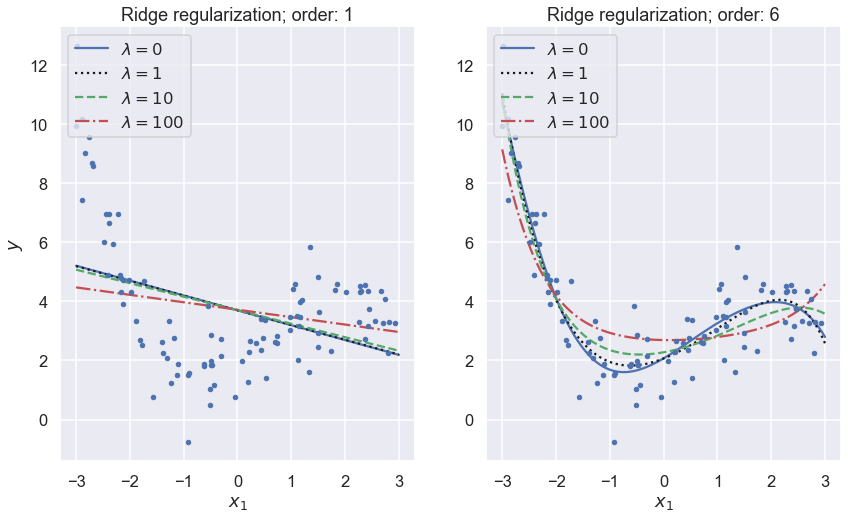

In [19]:
fig,axs = plt.subplots(1,2,figsize=(14,8))

lambdas=(0, 1,10, 100)
for i,degree in enumerate((1,6)):
    ax = axs[i]
    for lam, style in zip(lambdas, ("b-", "k:", "g--", "r-.")):
        y_new_regul = train_ridge_model(x, y, lam, x_predict=x_new, \
                                        degree=degree, random_state=42)
        ax.plot(x_new, y_new_regul, style, label=f'$\lambda={lam}$')
    ax.plot(x, y, "b.")
    ax.legend(loc="upper left")
    ax.set_xlabel("$x_1$")
    ax.set_title(f'Ridge regularization; order: {degree}')
    #ax.axis([0, 3, 0, 4])

axs[0].set_ylabel("$y$");

## k-fold cross validation

Code example to be added later.

## Learning curves

In order to gauge a model's generalization performance (predictive power) it is common to split the data into a *training set* and a *validation set*. We will also see examples of a third set called the *test set*.

**Learning curves** are plots of the model's performance on both the training and the validation sets, measured by some performance metric such as the mean squared error. This measure is plotted as a function of the size of the training set, or alternatively as a function of the training iterations.

In [22]:
# built-in convenience function for computing the MSE metric
from sklearn.metrics import mean_squared_error
# built-in convenience function for splitting data
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, x, y, ax=None):
    # split the data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.7, random_state=42)
    train_errors, val_errors = [], []
    for m in range(1, len(x_train)):
        model.fit(x_train[:m], y_train[:m])
        y_train_predict = model.predict(x_train[:m])
        y_val_predict = model.predict(x_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    if not ax:
        fig,ax = plt.subplots(1,1)
    ax.plot(np.sqrt(train_errors), "r-+", label="train")
    ax.plot(np.sqrt(val_errors), "b-", label="validation")
    ax.legend(loc="best")
    ax.set_xlabel("Training set size")
    ax.set_ylabel("MSE")

Let us use both a first-order and a high-order polynomial to model the training data and plot the learning curve. Recall that a low mean-square error implies that the model predicts the data very well.

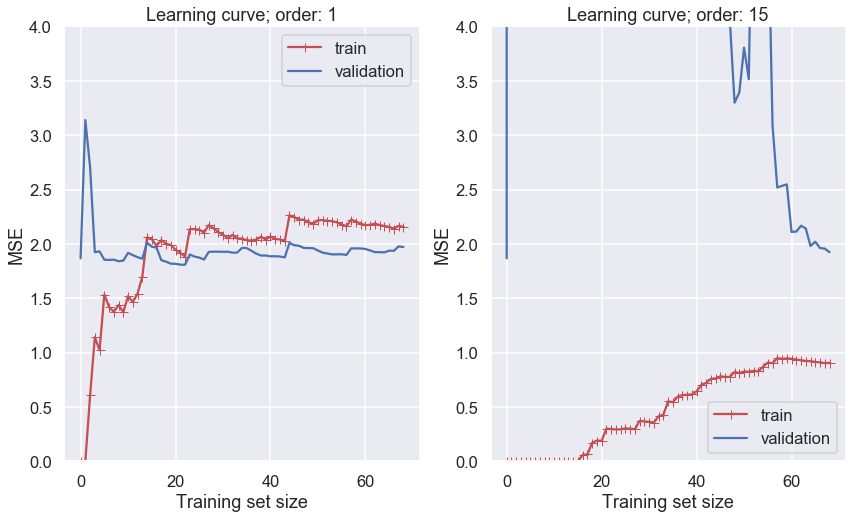

In [23]:
from sklearn.pipeline import Pipeline

fig,axs = plt.subplots(1,2,figsize=(14,8))

for i,degree in enumerate((1,15)):
    ax = axs[i]
    polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=degree, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

    plot_learning_curves(polynomial_regression, x, y, ax=ax)
    ax.set_title(f'Learning curve; order: {degree}')
    ax.set_ylim([0,4]);

Several features in the left-hand panel deserves to be mentioned:
1. The performance on the training set starts at zero when only 1-2 data are in the training set.
1. The error on the training set then increases steadily as more data is added. 
1. It finally reaches a plateau.
1. The validation error is initially very high, but reaches a plateau that is very close to the training error.

The learning curves in the right hand panel are similar to the underfitting model; but there are some important differences:
1. The training error is much smaller than with the linear model.
1. There is no clear plateau.
1. There is a gap between the curves, which implies that the model performs significantly better on the training data than on the validation set.

Both these examples that we have just studied demonstrate the so called **bias-variance tradeoff**.
- A high bias model has a relatively large error, most probably due to wrong assumptions about the data features.
- A high variance model is excessively sensitive to small variations in the training data.
- The irreducible error is due to the noisiness of the data itself. It can only be reduced by obtaining better data.

We seek a more systematic way of distinguishing between under- and overfitting models, and for quantification of the different kinds of errors. 

We will find that **Bayesian statistics** has the promise to deliver on that ultimate goal.